In [ ]:
import numpy as np
import pandas as pd
import cv2
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import filters
from skimage import util
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift, estimate_bandwidth
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive'

/content/drive/My Drive


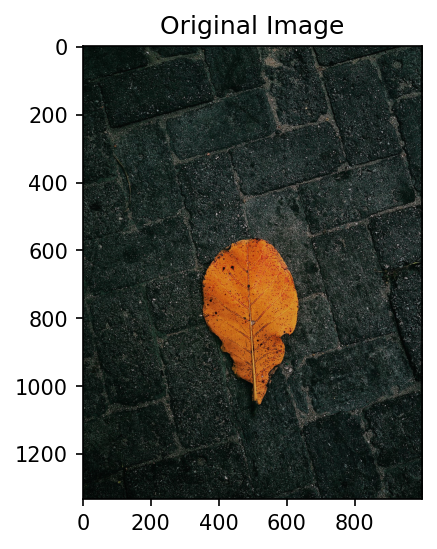

In [ ]:
imageName = 'leaf.jpg'
image_ = plt.imread(imageName)
plt.figure(dpi=150)
plt.title('Original Image')
plt.imshow(image_)

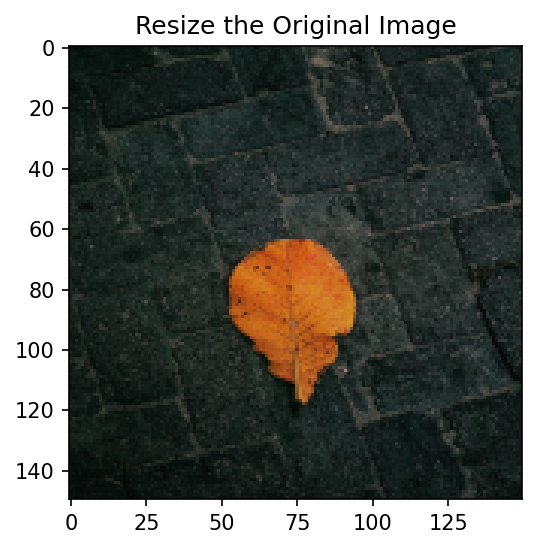

In [ ]:
image = cv2.imread(imageName, cv2.IMREAD_UNCHANGED)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (150,150), interpolation = cv2.INTER_AREA)
plt.figure(dpi=150)
plt.title('Resize the Original Image')
plt.imshow(image)

In [ ]:
index = pd.MultiIndex.from_product(
    (*map(range, image.shape[:2]), ('r', 'g', 'b')),
    names=('row', 'col', None))
df_1 = pd.Series(image.flatten(), index=index)
df_1 = df_1.unstack()
df_1 = df_1.reset_index().reindex(columns=['col','row',   'r','g','b'])
df_1.head(10)

,col,row,r,g,b
0,0,0,4,13,10
1,1,0,7,18,14
2,2,0,5,14,11
3,3,0,6,15,12
4,4,0,5,13,10
5,5,0,6,16,13
6,6,0,8,21,17
7,7,0,9,20,16
8,8,0,15,26,22
9,9,0,9,20,16


In [ ]:
df_2 = df_1[['r', 'g', 'b']]
df_2.head(10)

,r,g,b
0,4,13,10
1,7,18,14
2,5,14,11
3,6,15,12
4,5,13,10
5,6,16,13
6,8,21,17
7,9,20,16
8,15,26,22
9,9,20,16


In [ ]:
nd_1 = df_1.values.astype(np.float32)
nd_1[:, 0] = nd_1[:, 0] / (nd_1[:, 0].max() + 1)
nd_1[:, 1] = nd_1[:, 1] / (nd_1[:, 1].max() + 1)
nd_1[:, 2:] = nd_1[:, 2:] / 255
nd_2 = df_2.astype(np.float64) / 255

In [ ]:
nd_1 = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_1)
nd_2 = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_2)

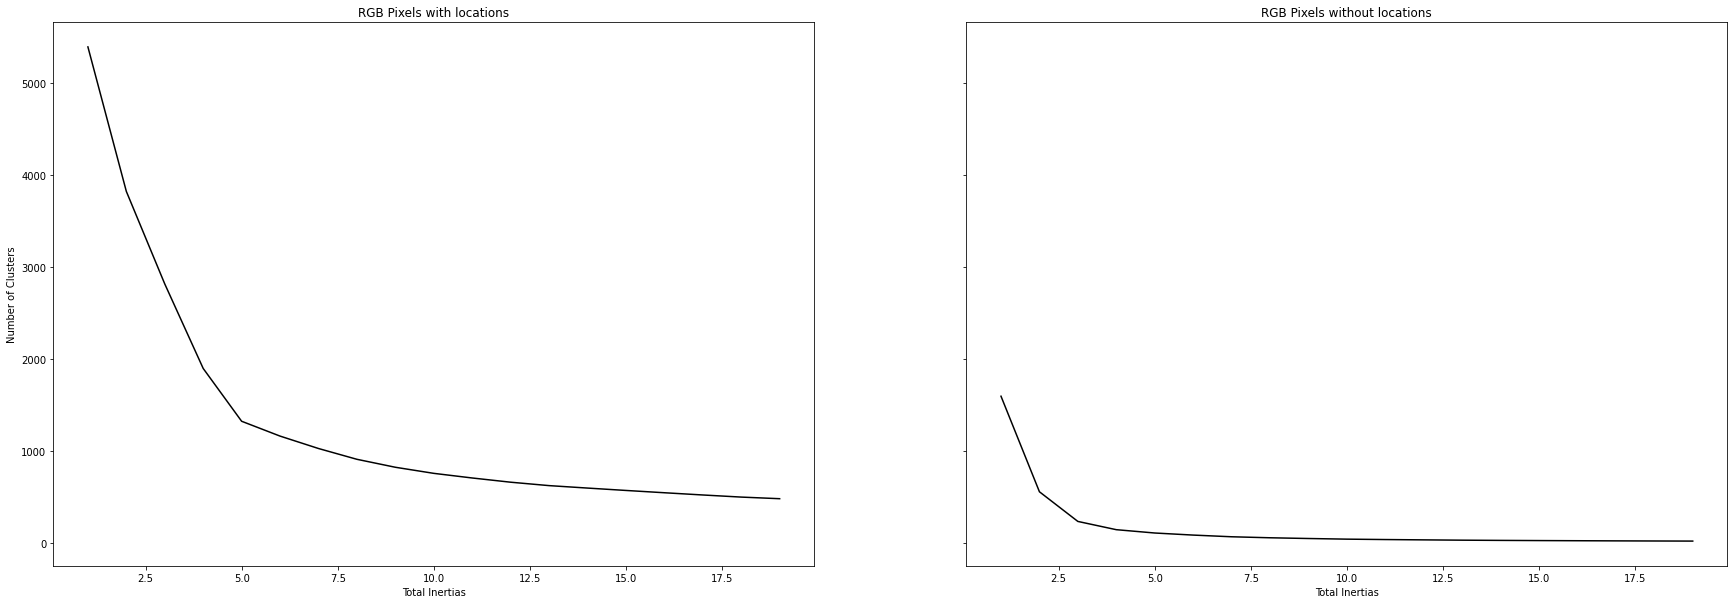

In [ ]:
total_inertias_1 = [KMeans(n_clusters=i).fit(nd_1).inertia_ for i in range(1, 20)]
total_inertias_2 = [KMeans(n_clusters=i).fit(nd_2).inertia_ for i in range(1, 20)]
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(30,10))
ax1.plot(range(1, 20), total_inertias_1, c='black')
ax1.set(xlabel='Total Inertias', ylabel='Number of Clusters', title='RGB Pixels with locations')
ax2.plot(range(1, 20), total_inertias_2, c='black')
ax2.set(xlabel='Total Inertias', title='RGB Pixels without locations');
plt.savefig('elbow_result.jpg')

In [ ]:
def image_segmentation(k, img_):
    Z = img_.reshape((-1,3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = k
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img_.shape))
    print("For K = ",k)
    plt.figure(dpi=150)
    plt.imshow(res2)


For K =  2


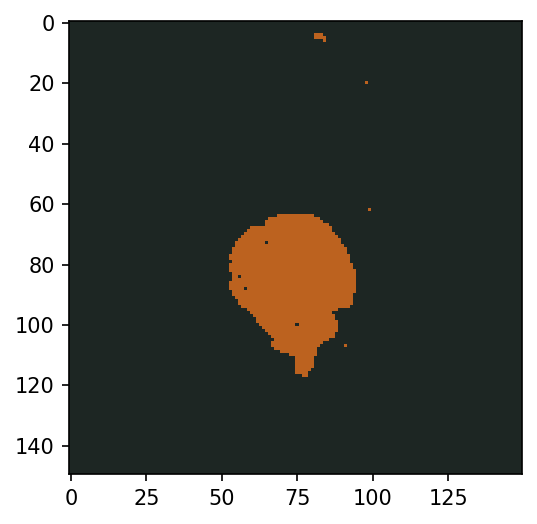

In [ ]:
image_segmentation(2,image)

For K =  3


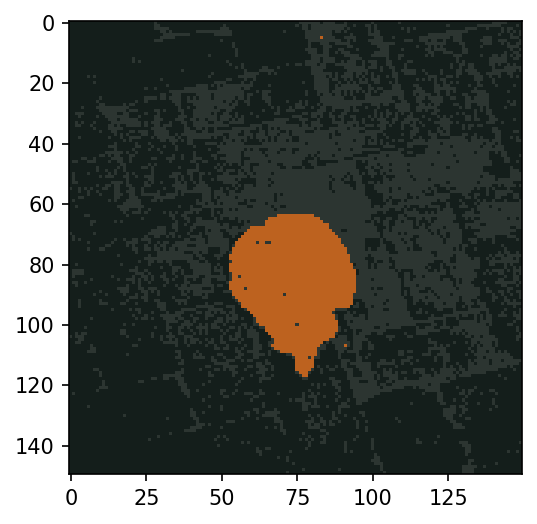

In [ ]:
image_segmentation(3,image)

For K =  5


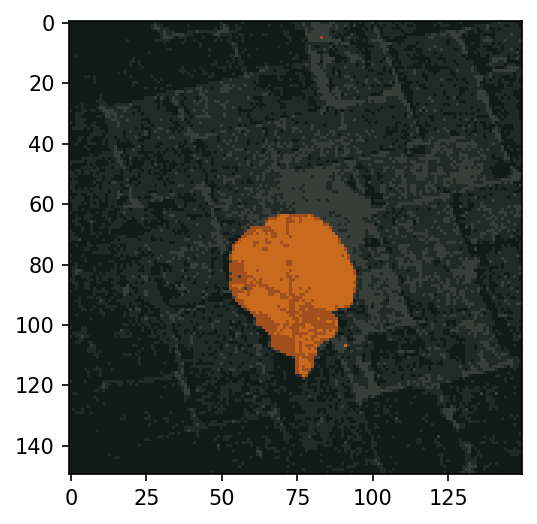

In [ ]:
image_segmentation(5,image)

when we compare image at K=3 vs K=5, we can observe that at k=5, image pixel is higher that image at k=3

In [ ]:
bandwidth_1 = estimate_bandwidth(nd_1, quantile=.04, n_jobs=-1)
bandwidth_2 = estimate_bandwidth(nd_2, quantile=.04, n_jobs=-1)

In [ ]:
ms_1 = MeanShift(bandwidth = bandwidth_1 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_1)
ms_2 = MeanShift(bandwidth = bandwidth_2 , n_jobs=-1, bin_seeding=True, cluster_all=True).fit(nd_2)

In [ ]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

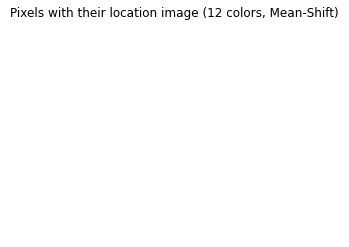

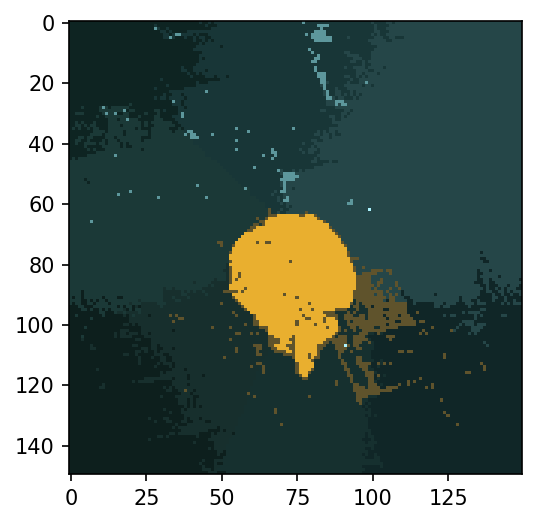

In [ ]:
plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Pixels with their location image ({} colors, Mean-Shift)'.format(len(ms_1.cluster_centers_)), loc='center')
plt.figure(dpi=150)
plt.imshow(recreate_image(ms_1.cluster_centers_[:, 2:], ms_1.labels_, image.shape[0], image.shape[1]));

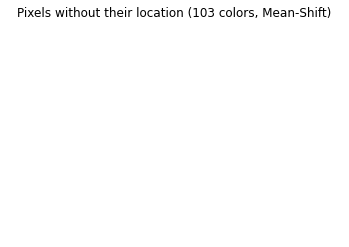

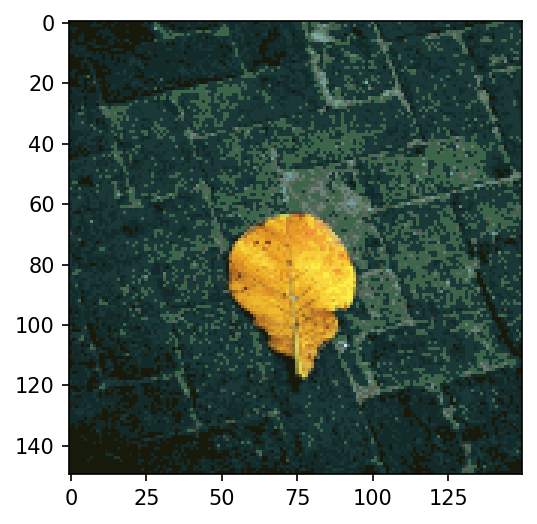

In [ ]:
plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Pixels without their location ({} colors, Mean-Shift)'.format(len(ms_2.cluster_centers_)), loc='center')
plt.figure(dpi=150)
plt.imshow(recreate_image(ms_2.cluster_centers_, ms_2.labels_, image.shape[0], image.shape[1]));